# Google Colaboratory を利用した ieinn ライブラリの使用例
Google Colaboratory(以下 Google Colab)を利用すれば、簡単に Python の実行環境を構築できます. GPU も無料で使用できます. ここでは Google Colab を利用した ieinn ライブラリの使用例を紹介します. 
## Google drive をマウントし, ieinn ライブラリを Google drive にダウンロードします。

In [ ]:
!git clone https://github.com/AoiHonda-lab/IEI-NeuralNetwork.git
%cd IEI-NeuralNetwork

## 必要なライブラリをインポートします

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import csv
from sklearn.model_selection import train_test_split
from ieinn import ieinn

GPUが使える場合は deviceに cuda を設定、そうでなければ cpu を設定します。

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## データの読み込み
データの読み込みと、訓練データと検証データへの分割などの処理をします。

In [3]:
df=pd.read_csv('CarEvaluation20221207_2.csv',encoding="shift-jis")
# df=pd.read_csv('normalized_car.csv')
df=df.drop(0,axis=0)
df=df.astype(float)

y=pd.DataFrame(df.iloc[:,0])
X=pd.DataFrame(df.iloc[:,1:])

#Normalize the objective variable

X=(X - X.min()) / (X.max() - X.min())
y=(y - y.min()) / (y.max() - y.min())

# data Generating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract as a numpy array with value and convert to tensor
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)

## データセット、データローダを作成
訓練データ、テストデータでそれぞれデータセットを作成し、これらを引数としてデータローダーを作成します。ミニバッチサイズやシャッフルの指定をします。

In [4]:
# Dataset creating
import os
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# DataLoade creating
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=128, 
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=2)

## 学習モデルの作成
インポートした ieinn の IE クラスでモデルを作成します。引数として、訓練データローダ－、ファジィ測度の加法性の次数、積分に用いる多項演算、前処理の種類を渡します。
訓練データローダは、上で作成した train_loader、加法性の次数は1から説明変数の数までの整数を渡します。多項演算は、論理積:Min、代数積:Algebraic、限界積:Lukasiewiczなどのt-norm が準備されています。前処理は、PreprocessingLayerPercentile, PreprocessingLayerStandardDeviation, PreprocessingLayerMaxMin から選べます。加法性次数、多項演算、前処理手法を指定しない場合、デフォルトはそれぞれ、完全非加法、代数積、PreprocessingLayerPercentile となっています。

In [5]:
model=ieinn.IE(train_loader, additivity_order=2, narray_op='Algebraic',preprocessing='PreprocessingLayerStandardDeviation', device=device).to(device)
criterion = nn.MSELoss() #loss function
optimizer = torch.optim.Adam(model.parameters()) #Optimization method
print(model)

IE(
  (preprocessing1): PreprocessingLayerStandardDeviation()
  (preprocessing2): PreprocessingLayerStandardDeviation()
  (preprocessing3): PreprocessingLayerStandardDeviation()
  (preprocessing4): PreprocessingLayerStandardDeviation()
  (preprocessing5): PreprocessingLayerStandardDeviation()
  (preprocessing6): PreprocessingLayerStandardDeviation()
  (iei): Algebraic()
  (output): OutputLayer()
)


## 学習前のパラメータを確認

In [6]:
model.state_dict()

OrderedDict([('preprocessing1.weight', tensor([[1.0083]])),
             ('preprocessing1.bias', tensor([-0.5100])),
             ('preprocessing2.weight', tensor([[1.0165]])),
             ('preprocessing2.bias', tensor([-0.5058])),
             ('preprocessing3.weight', tensor([[1.0041]])),
             ('preprocessing3.bias', tensor([-0.5011])),
             ('preprocessing4.weight', tensor([[0.9245]])),
             ('preprocessing4.bias', tensor([-0.4652])),
             ('preprocessing5.weight', tensor([[0.9169]])),
             ('preprocessing5.bias', tensor([-0.4578])),
             ('preprocessing6.weight', tensor([[0.9170]])),
             ('preprocessing6.bias', tensor([-0.4538])),
             ('output.weight',
              tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000,
                       0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                       0.0000, 0.0000, 0.0000]])),
             ('output.bias

## 学習の実行

In [7]:
history=model.fit_and_valid(train_loader, test_loader, criterion, optimizer, epochs=300, regularization=True, mono_lambda=0.2)

Epoch [1/300], loss: 0.15653938 val_loss: 0.12747598


KeyboardInterrupt: 

## 学習結果の表示
学習後の決定係数、パラメータ、学習曲線を表示します。

In [9]:
model.r2_score(test_loader)

cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu
re
cpu


0.018250182779579682

In [145]:
model.r2_score(test_loader, device)

0.6067948412503883

In [146]:
#np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)
model.state_dict()

OrderedDict([('preprocessing1.weight', tensor([[2.0159]])),
             ('preprocessing1.bias', tensor([-1.1331])),
             ('preprocessing2.weight', tensor([[1.9763]])),
             ('preprocessing2.bias', tensor([-0.9921])),
             ('preprocessing3.weight', tensor([[1.1822]])),
             ('preprocessing3.bias', tensor([-0.6694])),
             ('preprocessing4.weight', tensor([[2.8248]])),
             ('preprocessing4.bias', tensor([-0.3687])),
             ('preprocessing5.weight', tensor([[1.6614]])),
             ('preprocessing5.bias', tensor([-0.8422])),
             ('preprocessing6.weight', tensor([[2.1693]])),
             ('preprocessing6.bias', tensor([-1.0117])),
             ('output.weight',
              tensor([[0.0045, 0.0011, 0.0554, 0.0021, 0.0032, 0.0027, 0.0389, 0.0280, 0.2111,
                       0.1112, 0.3382, 0.0437, 0.1893, 0.1030, 0.2522, 0.0058, 0.0519, 0.0074,
                       0.1166, 0.3738, 0.0766]])),
             ('output.bias

In [147]:
model.test_monotone()

[]

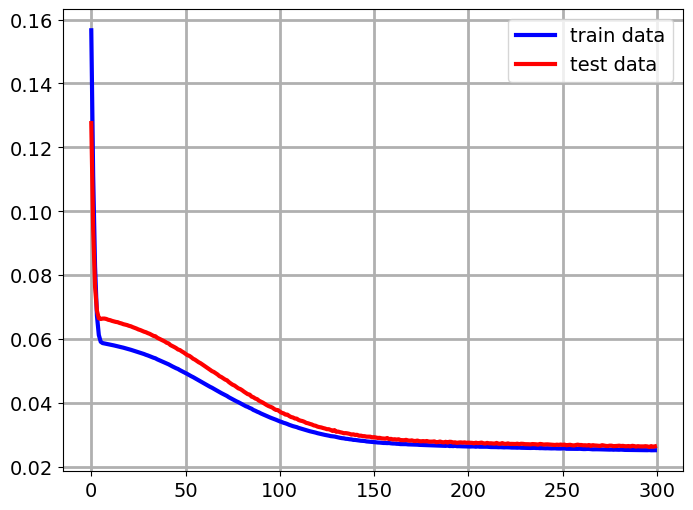

0

In [148]:
model.plot()

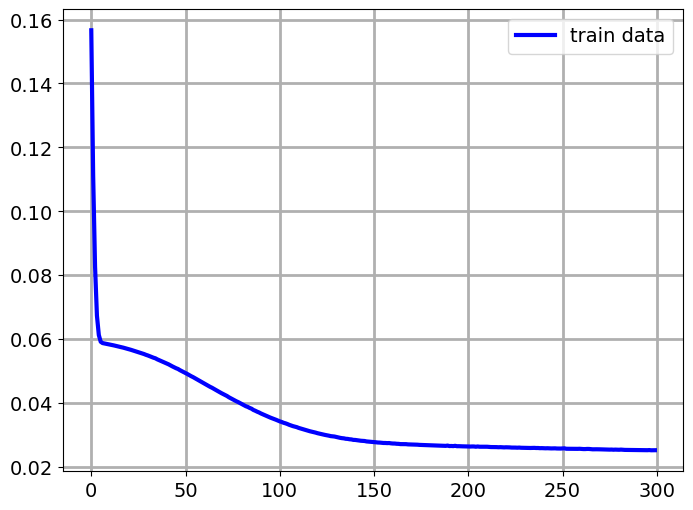

0

In [149]:
model.plot_train()

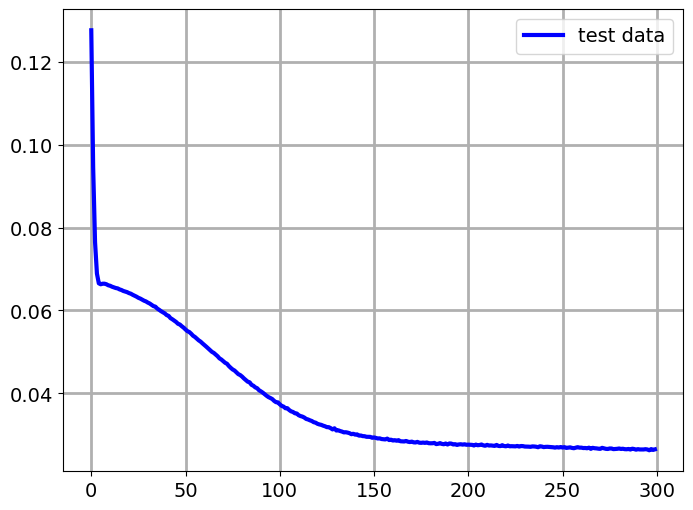

0

In [150]:
model.plot_test()

In [151]:
model.test_monotone()

[]

In [155]:
model.mobius_to_fuzzy()

{(): 0.0,
 (1,): 0.0044551813043653965,
 (2,): 0.0011277684243395925,
 (3,): 0.05536683276295662,
 (4,): 0.0020589055493474007,
 (5,): 0.0032357180025428534,
 (6,): 0.002683709841221571,
 (1, 2): 0.044447096646763384,
 (1, 3): 0.08781440975144506,
 (1, 4): 0.21760766161605716,
 (1, 5): 0.11891969316639006,
 (1, 6): 0.3453544806689024,
 (2, 3): 0.10019983735401183,
 (2, 4): 0.19246810779441148,
 (2, 5): 0.1073868292151019,
 (2, 6): 0.2559943195665255,
 (3, 4): 0.06320476485416293,
 (3, 5): 0.11048760800622404,
 (3, 6): 0.06541845016181469,
 (4, 5): 0.12184712546877563,
 (4, 6): 0.37854739325121045,
 (5, 6): 0.08252577600069344,
 (1, 2, 3): 0.17151156126055866,
 (1, 2, 4): 0.44688101077917963,
 (1, 2, 5): 0.2619349512970075,
 (1, 2, 6): 0.6375292373122647,
 (1, 3, 4): 0.3067459166049957,
 (1, 3, 5): 0.2541639788541943,
 (1, 3, 6): 0.43608161667361856,
 (1, 4, 5): 0.4486246753949672,
 (1, 4, 6): 0.9323117388412356,
 (1, 5, 6): 0.5364253406878561,
 (2, 3, 4): 0.29731920326594263,
 (2, 3, 5

In [153]:
model.shapley()

{(1,): 0.3681524316780269,
 (2,): 0.31465626892168075,
 (3,): 0.12373164435848594,
 (4,): 0.4503145630005747,
 (5,): 0.23288373998366296,
 (6,): 0.526772442040965}

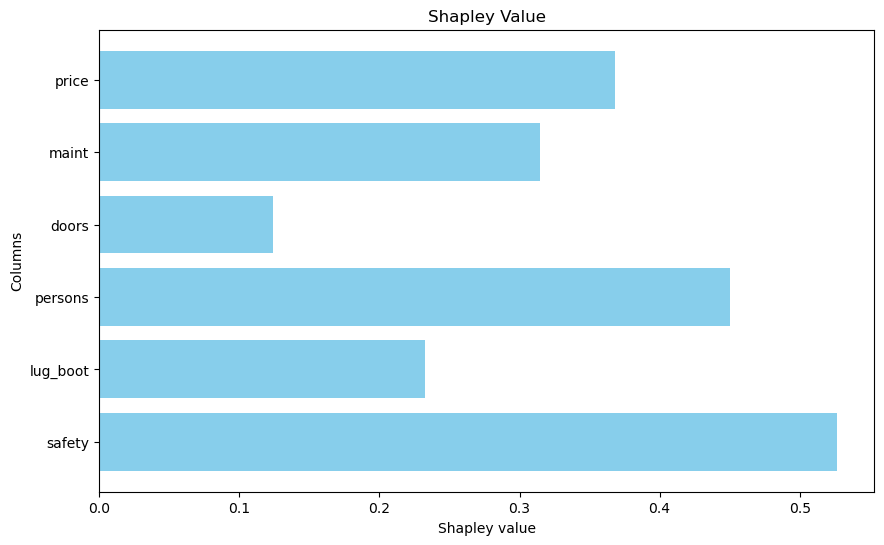

0

In [154]:
model.shapley_plot(X.columns)

In [8]:
model

IE(
  (preprocessing1): PreprocessingLayerStandardDeviation()
  (preprocessing2): PreprocessingLayerStandardDeviation()
  (preprocessing3): PreprocessingLayerStandardDeviation()
  (preprocessing4): PreprocessingLayerStandardDeviation()
  (preprocessing5): PreprocessingLayerStandardDeviation()
  (preprocessing6): PreprocessingLayerStandardDeviation()
  (iei): Algebraic()
  (output): OutputLayer()
)

In [9]:
def shapley(model):
        additivity_sets = (model.power_sets_additivity_order()) 
        output_weight = (model.output.weight).to('cpu').detach().numpy().copy()
        
        output_weight_list = output_weight[0].tolist()
        output_weight_list.insert(0, 0)
        data = np.array(output_weight_list)
        dict_fuzzy = dict(zip(additivity_sets, data))
        print(dict_fuzzy)
        shapley = []
        for i in range(1, model.columns_num+1):
            shapley_value = 0
            A = additivity_sets[i]
            for B in additivity_sets:
                if set(A) <= set(B):
                    shapley_value += dict_fuzzy[B] / len(B)
            shapley.append(shapley_value) 
        print(shapley)
        shapley = dict(zip(additivity_sets[1:], shapley))
        return shapley

In [11]:
import numpy as np
shapley(model)

{(): 0.0, (1,): 0.14560826122760773, (2,): 0.14558738470077515, (3,): 0.14555609226226807, (4,): 0.1456376165151596, (5,): 0.14559528231620789, (6,): 0.1456233412027359, (1, 2): -0.021002117544412613, (1, 3): -0.02104523777961731, (1, 4): -0.020955894142389297, (1, 5): -0.021004164591431618, (1, 6): -0.020959464833140373, (2, 3): -0.021075021475553513, (2, 4): -0.02097926288843155, (2, 5): -0.021007023751735687, (2, 6): -0.020979056134819984, (3, 4): -0.0210166797041893, (3, 5): -0.021069323644042015, (3, 6): -0.021022910252213478, (4, 5): -0.020974379032850266, (4, 6): -0.020925387740135193, (5, 6): -0.02098822221159935}
[0.09312482178211212, 0.09306614380329847, 0.09294150583446026, 0.0932118147611618, 0.09307372570037842, 0.09318582061678171]


{(1,): 0.09312482178211212,
 (2,): 0.09306614380329847,
 (3,): 0.09294150583446026,
 (4,): 0.0932118147611618,
 (5,): 0.09307372570037842,
 (6,): 0.09318582061678171}

In [ ]:
(self.output.weight).to('cpu').detach().numpy().copy()

In [19]:
model.output.weight[0]#.to('cpu').detach().numpy().copy()

tensor([ 0.1456,  0.1456,  0.1456,  0.1456,  0.1456,  0.1456, -0.0210, -0.0210,
        -0.0210, -0.0210, -0.0210, -0.0211, -0.0210, -0.0210, -0.0210, -0.0210,
        -0.0211, -0.0210, -0.0210, -0.0209, -0.0210],
       grad_fn=<SelectBackward0>)